In [1]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from utils import *
from scipy.fft import fft
import os
from jax import random
from jax.experimental.optimizers import adam, sgd
from jax import numpy as jnp
%load_ext autoreload
%autoreload 2
from models.newton_neural import mse, initialize_params, batch_forward_pass, get_loss_function, train, forward_pass, forward_neural_network
from tqdm import tqdm
from utils import Shuffler


/home/felipeangelim/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
def get_vectors_from_data(df):
    q = np.expand_dims(df[['x', 'y']].values, axis=-1)
    q_dot = np.expand_dims(df[['x_dot', 'y_dot']].values, axis=-1)
    q_dot2 = np.expand_dims(df[['x_dot2', 'y_dot2']].values, axis=-1)
    f = np.expand_dims(df[['fx', 'fy']].values, axis=-1)
    return q, q_dot, q_dot2, f


def optimize(params, q, q_dot, q_dot2, f, batch_size=32, step_size=1e-1, epochs=5, window=6000,):

    rng = random.PRNGKey(15)

    shuffler = Shuffler(len(q))
    q_shuffled = shuffler.shuffle(q)
    q_dot_shuffled = shuffler.shuffle(q_dot)
    q_dot2_shuffled = shuffler.shuffle(q_dot2)
    f_shuffled = shuffler.shuffle(f)
    
    
    def callback(y_pred, y_true):

        plt.figure(figsize=(10, 8))
        random_ind = int(np.random.uniform(0, len(y_pred) - window - 1))
        plt.plot(shuffler.undo_shuffle(np.squeeze(y_pred))[random_ind:(random_ind + window)], linestyle="dotted")
        plt.plot(shuffler.undo_shuffle(np.squeeze(y_true))[random_ind:(random_ind + window)])
        plt.show()


    params=train(params, q_shuffled, q_dot_shuffled, q_dot2_shuffled, f_shuffled, batch_size=batch_size, optimizer=adam, step_size=step_size, epochs=epochs, callback=callback, batch_forward_pass=batch_forward_pass)
    return params


In [3]:
rng = random.PRNGKey(15)
params = initialize_params(rng, layers=[4, 300, 300 ,4], scale=1)

In [4]:
forward_pass(params, q = np.array([1, 1]).reshape((-1, 1)), q_dot = np.array([1, 1]).reshape((-1, 1)), f=np.array([1, 1]).reshape((-1, 1)))

DeviceArray([-1730.4741,   853.4291], dtype=float32)

In [5]:
df_train = pd.read_csv("../amb_other/sweep_train.csv")

In [6]:
q, q_dot, q_dot2, f = get_vectors_from_data(df_train)

In [7]:
batch_forward_pass(params, q, q_dot, f)

DeviceArray([[1.8381889e+09, 1.5319743e+09],
             [1.8111064e+09, 1.5092681e+09],
             [1.7852493e+09, 1.4876105e+09],
             ...,
             [2.4984924e+09, 5.8975622e+08],
             [2.5594376e+09, 5.9144787e+08],
             [2.6208589e+09, 5.9238662e+08]], dtype=float32)

In [8]:
forward_neural_network(params["K"], jnp.concatenate([q, q_dot], axis=-1)[1000].reshape((-1,)))

DeviceArray([ 14609.72 ,  13231.255,  18967.9  , -11631.328], dtype=float32)

  0%|          | 0/2160 [00:00<?, ?it/s]

Epoch 0


100%|██████████| 2160/2160 [01:06<00:00, 32.52it/s]


Epoch 0 , mean error: 1329372.5


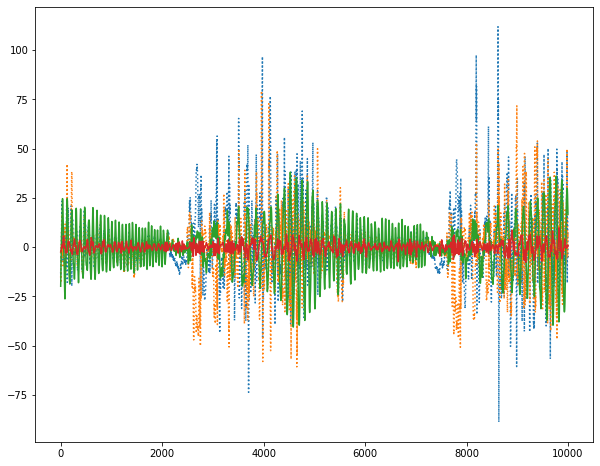

  0%|          | 3/2160 [00:00<01:44, 20.62it/s]

Epoch 1


 11%|█         | 231/2160 [00:07<01:04, 29.75it/s]


KeyboardInterrupt: 

In [7]:
params = optimize(params, q, q_dot, q_dot2, f, batch_size=64, step_size=1e-1, epochs=5, window=10000)

In [14]:
# Dados sinusoidais
def get_data(freq, polyorder=3, window_length=151):
    
    all_data = pd.DataFrame()
    for file in filter(lambda x: ("_"+str(freq)+"Hz" in x) and x.endswith(".txt"), os.listdir("../amb_sin/")):
        print(file)
        df = load_amb_sin_data("../amb_sin/" + file).iloc[10000:]
        df["f_ay"] -= df["f_ay"].mean()
        df["f_ax"] -= df["f_ax"].mean()
        df["f_bx"] -= df["f_bx"].mean()
        df["f_by"] -= df["f_by"].mean()
        df["x"] = (df["ax"] + df["bx"])/2
        #df["x"] = df["ax"]
        df["y"] = (df["ay"] + df["by"])/2
        #df["y"] = df["ay"]
        df['fx'] = df["f_ax"] + df["f_bx"]
        #df["fx"] = df["f_ax"]
        df['fy'] = df["f_ay"] + df["f_by"]
        #df["fx"] = df["f_ay"]
        df = df[["datetime", "x", "y", "fx", "fy"]]
        mean_dt = (df["datetime"] - df["datetime"].shift()).median().delta*1e-9
        for col in ["x", "y"]:
            df = append_derivatives_to_dataframe(df, col, dt=mean_dt, window_length=window_length, polyorder=polyorder)

        df = append_derivatives_to_dataframe(df, "fx", dt=mean_dt, window_length=window_length, polyorder=polyorder)
        df = append_derivatives_to_dataframe(df, "fy", dt=mean_dt, window_length=window_length, polyorder=polyorder)

        all_data = pd.concat([all_data, df], ignore_index=True)
    
    return all_data


data_sin = get_data(freq=5)

sine_fx_5Hz_0RPM.txt
sine_fy_5Hz_0RPM.txt


In [15]:
q_sin, q_dot_sin, q_dot2_sin, f_sin = get_vectors_from_data(data_sin)

In [16]:
y_pred = np.squeeze(batch_forward_pass(params, q_sin, q_dot_sin, f_sin))
y_true = np.squeeze(q_dot2_sin)[:]

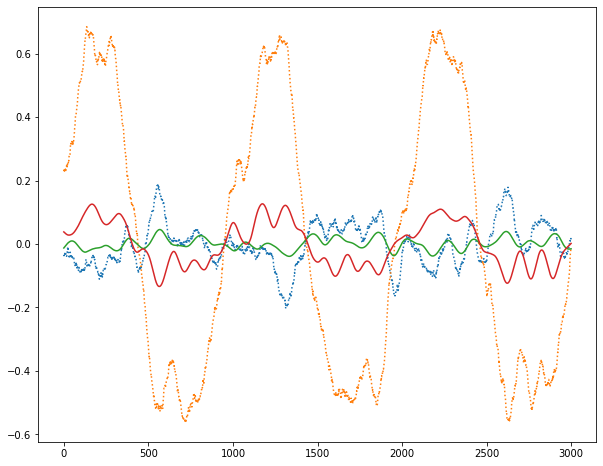

In [17]:
window = 3000
random_ind = int(np.random.uniform(0, len(y_pred) - window - 1))


y_true_window = y_true[random_ind:(random_ind + window)]
y_pred_window = y_pred[random_ind:(random_ind + window)]
factor = (np.squeeze(y_true_window).max(axis=0) - np.squeeze(y_true_window).min(axis=0))/(np.squeeze(y_pred_window).max(axis=0) - np.squeeze(y_pred_window).min(axis=0))
factor=1
plt.figure(figsize=(10, 8))
plt.plot(y_pred_window*factor, linestyle="dotted")
plt.plot(y_true_window)
plt.show()

In [24]:
print(forward_neural_network(params["K"], jnp.concatenate([q, q_dot], axis=-1)[1000].reshape((-1,))))
print(forward_neural_network(params["C"], jnp.concatenate([q, q_dot], axis=-1)[1000].reshape((-1,))))

[176.19136   71.6172    -8.087604 180.42464 ]
[  9.029715  -4.528267 -10.90778    7.585379]


In [21]:
jnp.concatenate([q, q_dot], axis=-1)[0].reshape((-1, 1))

DeviceArray([[ 1.974514e-05],
             [-8.522581e-04],
             [-2.623840e-06],
             [ 1.540591e-03]], dtype=float32)

In [123]:
y_true*factor

DeviceArray([[ 1.5345621 , -0.8357192 ],
             [ 1.5357382 , -0.82771885],
             [ 1.5369146 , -0.8197185 ],
             ...,
             [ 0.38692477, -1.3563743 ],
             [ 0.39340052, -1.3825717 ],
             [ 0.3998762 , -1.4087691 ]], dtype=float32)

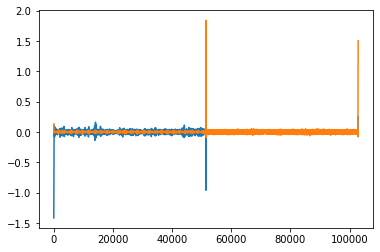

In [136]:
plt.plot(y_true)

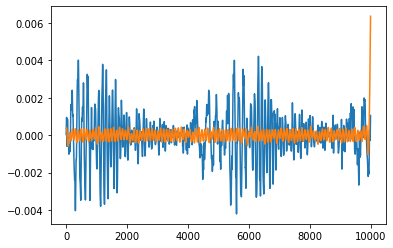

In [112]:
plt.plot(q_dot[-10000:, 0])
plt.plot(q_dot_sin[-10000:, 0])

In [113]:
params["K"]

[(DeviceArray([[ 9.11181986e-01,  3.10838044e-01, -1.15137947e+00,
                -1.16548864e-02],
               [ 5.40337622e-01, -2.00264409e-01,  1.67556012e+00,
                -1.36389029e+00],
               [-9.05349135e-01,  5.64371824e-01, -2.05712175e+00,
                -1.41786385e+00],
               [ 1.33903396e+00,  1.82581079e+00, -1.48867190e+00,
                -1.96327114e+00],
               [ 1.08904517e+00, -7.28818849e-02, -2.69749141e+00,
                 4.86783117e-01],
               [ 2.93495417e-01, -1.40477464e-01, -5.74378109e+00,
                -1.13848114e+00],
               [ 5.82451403e-01, -1.79771340e+00, -1.90574586e-01,
                 3.78542721e-01],
               [-2.18973249e-01, -7.03626573e-01,  3.05457652e-01,
                 1.87227324e-01],
               [-6.77020907e-01, -7.42552336e-03, -2.08836102e+00,
                -1.86750579e+00],
               [-4.51445404e+02, -6.46763672e+02,  9.75756348e+02,
                 9.98902